## Business Problem


Assignment 4A:
- Download this zipped file (Links to an external site.).
- Unzip it and understand how you need to use it to tag images
- You'll receive a separate email with 100 images. You need to add these images to your project and tag them
- You need to tag a face (if it is there, else create any rectangular area near the face), and select the options available in the annotation window. 
- Upload:
  - your images folder
  - saved project file (json)
  - saved annotation file (json)
  - Submit these inside Assignment 4 folder as Assignment 4A

Assignment 4B:
- Use this code to create ResNet18 (Links to an external site.) Network 
- Train on CIFAR10 data.  
- Run for 50 Epochs and cross 88% Validation Accuracy
- Show GradCam results for 10 images. 
- Submit on GitHub as Assignment 4B Folder inside Assignment 4 Folder


## Initial Libs and Input Data Loading

In [0]:
# from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
# import keras.applications as  applications
# from keras.models import Sequential
# from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
# from keras.layers import Activation, Flatten, Dense, Dropout, Add, BatchNormalization, GlobalAveragePooling2D
# from keras.layers.normalization import BatchNormalization
# from keras.utils import np_utils
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras import backend as K


In [0]:
from keras.datasets import cifar10
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


170500096/170498071 [==============================] - 2s 0us/step


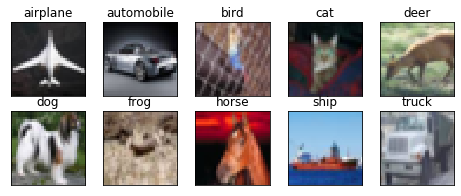

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
## Function gives the accuracy on test data
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
os.chdir('/content/')
!pwd
!ls -ltr

/content
total 4
drwxr-xr-x 1 root root 4096 Nov 21 16:30 sample_data


In [0]:
!rm -rf deeplearning

!git clone https://github.com/amitkml/deeplearning.git
!ls -ltr
!pwd

Cloning into 'deeplearning'...
remote: Enumerating objects: 278, done.
remote: Total 278 (delta 0), reused 0 (delta 0), pack-reused 278
Receiving objects: 100% (278/278), 6.82 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (133/133), done.
total 8
drwxr-xr-x 1 root root 4096 Nov 21 16:30 sample_data
drwxr-xr-x 6 root root 4096 Dec  4 05:05 deeplearning
/content


In [0]:
from deeplearning.tensorflow import generate_cifar10_tfrecords as tfcifar  ## This is for generating tfrecord in TF 1.14
from deeplearning.tensorflow import read_cifar10_tfrecords as readtfcifar  ## This is for reading tfrecord of cifar10 in TF 1.14
from deeplearning.tensorflow import show_metrices as show_metrices  ## Showing different metrices
from deeplearning.tensorflow import learning_rate_scheduler as learning_rate_scheduler  ## different leaerning rate scheduler
from deeplearning.tensorflow import show_metrices_cifar100 as show_metrices_cifar100  ## different leaerning rate scheduler
from deeplearning.tensorflow import show_metrices as show_metrices  ## different leaerning rate scheduler

os.chdir('/content/')
!pwd

/content


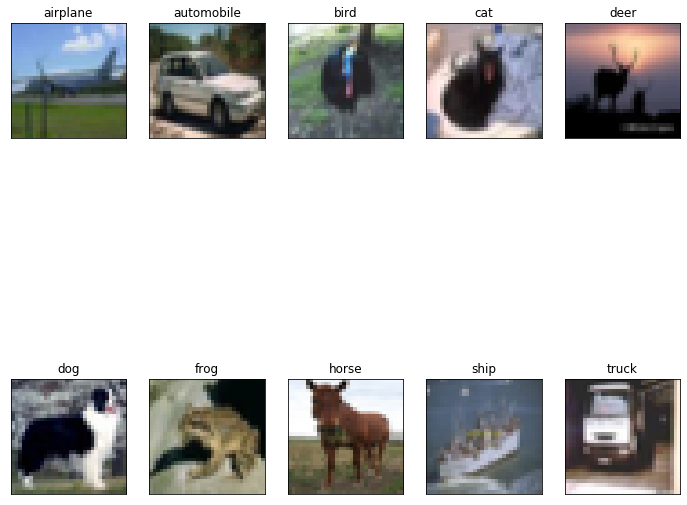

In [0]:
show_metrices.display_each_class_one_cifar10()

In [0]:
## adding cutout
os.chdir('/content')
!git clone https://github.com/yu4u/cutout-random-erasing.git
!ls -ltr
!pwd

os.chdir('/content/cutout-random-erasing')
from random_eraser import get_random_eraser
os.chdir('/content')


Cloning into 'cutout-random-erasing'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.
total 12
drwxr-xr-x 1 root root 4096 Nov 21 16:30 sample_data
drwxr-xr-x 6 root root 4096 Dec  4 05:05 deeplearning
drwxr-xr-x 3 root root 4096 Dec  4 05:05 cutout-random-erasing
/content


## Model Development

**Strategy Taken for Model Finetunement**
- Changed Stride value of 2 to 1
- Added Image augmentation of Flip with probability of 0.5
- Added Cyclic Learning Rate
- Have changed the optimiser from Adap to SGD
- Have used momentum and weight decay

**Key Achievements**
- Achieved accuracy of 93.23% accuracy within 50 epocj
- Have used own github module for generating confusion matrix and gradcam


In [0]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True


In [0]:
# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------

In [0]:
n = 3
# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
# version =2
version = 2
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [0]:
subtract_pixel_mean = True
num_train, img_channels, img_rows, img_cols =  x_train.shape
num_test, _, _, _ =  x_test.shape
num_classes = len(np.unique(y_train))

In [0]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
  print("Pixel Substraction Mean Done")
  x_train_mean = np.mean(x_train, axis=0)
  x_train -= x_train_mean
  x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

Pixel Substraction Mean Done
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # strides = 2  # downsample
                strides = 1  # downsample amit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    print("Shape:",x.shape)
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    y = Conv2D(filters=10, kernel_size=(1,1), padding='same',activation='softmax')(x)
    # print("GAP Shape:",y.shape)
    # outputs = GlobalAveragePooling2D()(y)
    # print("GAP output:",outputs.shape)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    # num_filters_in = 16
    num_filters_in = 32 # AMIT
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    print("Shape:",x.shape)
    
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    # y = Conv2D(filters=10, kernel_size=(1,1), padding='same',activation='softmax')(x)
    # print("GAP Shape:",y.shape)
    # outputs = GlobalAveragePooling2D()(y)
    # print("GAP output:",outputs.shape)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
!git clone https://github.com/amitkayal/keras-one-cycle.git
!ls -ltr
!pwd

import os

Cloning into 'keras-one-cycle'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 238 (delta 18), reused 0 (delta 0), pack-reused 208
Receiving objects: 100% (238/238), 3.19 MiB | 19.23 MiB/s, done.
Resolving deltas: 100% (100/100), done.
total 16
drwxr-xr-x 1 root root 4096 Nov 21 16:30 sample_data
drwxr-xr-x 6 root root 4096 Dec  4 05:05 deeplearning
drwxr-xr-x 4 root root 4096 Dec  4 05:05 cutout-random-erasing
drwxr-xr-x 5 root root 4096 Dec  4 05:05 keras-one-cycle
/content


In [0]:
os.chdir('/content/keras-one-cycle/')
!pwd

from clr import LRFinder
from clr import OneCycleLR

os.chdir('/content/')
!pwd

/content/keras-one-cycle
/content


In [0]:
import tensorflow as tf
from keras.optimizers import RMSprop, SGD

if version == 2:
  print("ResnetV2")
  model = resnet_v2(input_shape=input_shape, depth=depth)
else:
  print("ResnetV1")
  model = resnet_v1(input_shape=input_shape, depth=depth)

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(lr=lr_schedule(0)),
#               metrics=['accuracy'])

sgd = SGD(decay=1e-4, lr=1, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


model.summary()
print(model_type)

ResnetV2











Shape: (?, 8, 8, 512)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
_______________________________________________

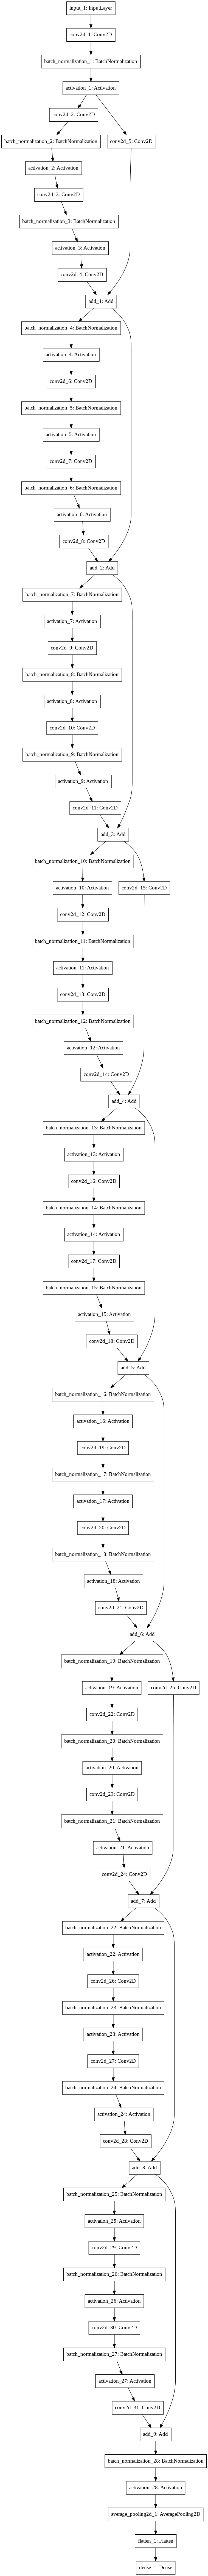

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model_assignment4_pure_resnet.png')

from IPython.display import Image

Image(filename='model_assignment4_pure_resnet.png')

In [0]:
max_lr=.31  ## This is taken from LR Finder
epoch = 50

num_samples = x_train.shape[0]
num_epoch = 50  #@param {type:"slider", min:0, max:100, step:1}
end_percentage =0.1
scale_percentage = None
maximum_momentum=0.95 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
minimum_momentum=0.9 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
# batch_size = '512'
batch_size= 128 #@param ["512", "256", "128", "64"] {type:"raw"}

In [0]:
lr_manager = OneCycleLR(num_samples=num_samples, batchsize=batch_size, max_lr=max_lr, maximum_momentum=0.9, verbose=True)


In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)


lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               verbose=1,
                               cooldown=0,
                               patience=1,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]
callbacks = [checkpoint, lr_reducer]

callbacks = [lr_manager,checkpoint]

In [0]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

In [0]:
pixel_level = False
cutoutpreprocessing_function=get_random_eraser(p=0.15, s_l=0.002, s_h=0.005, pixel_level=pixel_level)

In [0]:
from imgaug import augmenters as iaa

seqVal = iaa.Sequential([
#     iaa.Affine(rotate=(-25, 25)),
#     iaa.AdditiveGaussianNoise(scale=(10, 60)),
    iaa.Fliplr(0.5) ,
#     iaa.CropAndPad(px=(0, 4),pad_mode="edge")
], random_order=True)

In [0]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        # zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        # width_shift_range=0.1,
        # randomly shift images vertically
        # height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        # zoom_range=0.,
        zoom_range=0.25,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        # preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        preprocessing_function=seqVal.augment_image,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

Using real-time data augmentation.


In [0]:
# def scheduler(epoch, lr):
#   return round(0.032 * 1/(1 + 0.219 * epoch), 10)

# callbacks = [checkpoint, LearningRateScheduler(scheduler, verbose=1)]

  

In [0]:
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Class: <clr.OneCycleLR object at 0x7f57c1f04588>
Values: {'validation_data': None, 'model': <keras.engine.training.Model object at 0x7f5819d2a898>, 'initial_lr': 0.31, 'end_percentage': 0.1, 'scale': 0.1, 'max_momentum': 0.9, 'min_momentum': 0.85, 'verbose': True, '_update_momentum': True, 'clr_iterations': 0.0, 'history': {}, 'epochs': None, 'batch_size': 128, 'samples': 50000, 'steps': None, 'num_iterations': None, 'mid_cycle_id': None, 'params': {'epochs': 50, 'steps': 391, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}}
Epoch 1/50
391/391 [==============================] - 149s 381ms/step - loss: 2.7947 - acc: 0.4154 - val_loss: 3.1158 - val_acc: 0.3993
 - lr: 0.04314 - momentum: 0.90 

Epoch 00001: val_acc improved from -inf to 0.39930, saving model to /content/saved_models/cifar10_ResNet29v2_model.h5
Epoch 2/50
391/391 [=========================

In [0]:
model.load_weights('/content/saved_models/cifar10_ResNet29v2_model.h5')

In [0]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 11s 1ms/step
Test loss: 0.43834381585121157
Test accuracy: 0.9323


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
# currentDT = datetime.datetime.now()
# print("Current time:", currentDT)

In [0]:
# # plot model history
# plot_model_history(model)
# # compute test accuracy
# print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, modelmod))

In [0]:
Y_pred = model.predict(x_test)
CFMatrix = show_metrices.show_classification_matrix(Y_pred,y_test)


Confusion matrix:
[[938   8  17   6   2   0   3   1  17   8]
 [  1 980   1   1   2   0   0   0   2  13]
 [ 13   0 921  11  15  10  21   5   4   0]
 [  5   4  24 852  18  57  29   7   3   1]
 [  1   0  11  15 940   7  13  13   0   0]
 [  5   1  17  68  13 876  11   7   0   2]
 [  4   1  13   8   1   3 967   0   2   1]
 [  4   1   5  11  18   9   2 949   1   0]
 [ 22   7   5   2   0   0   2   0 955   7]
 [  4  40   2   3   0   0   0   0   6 945]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

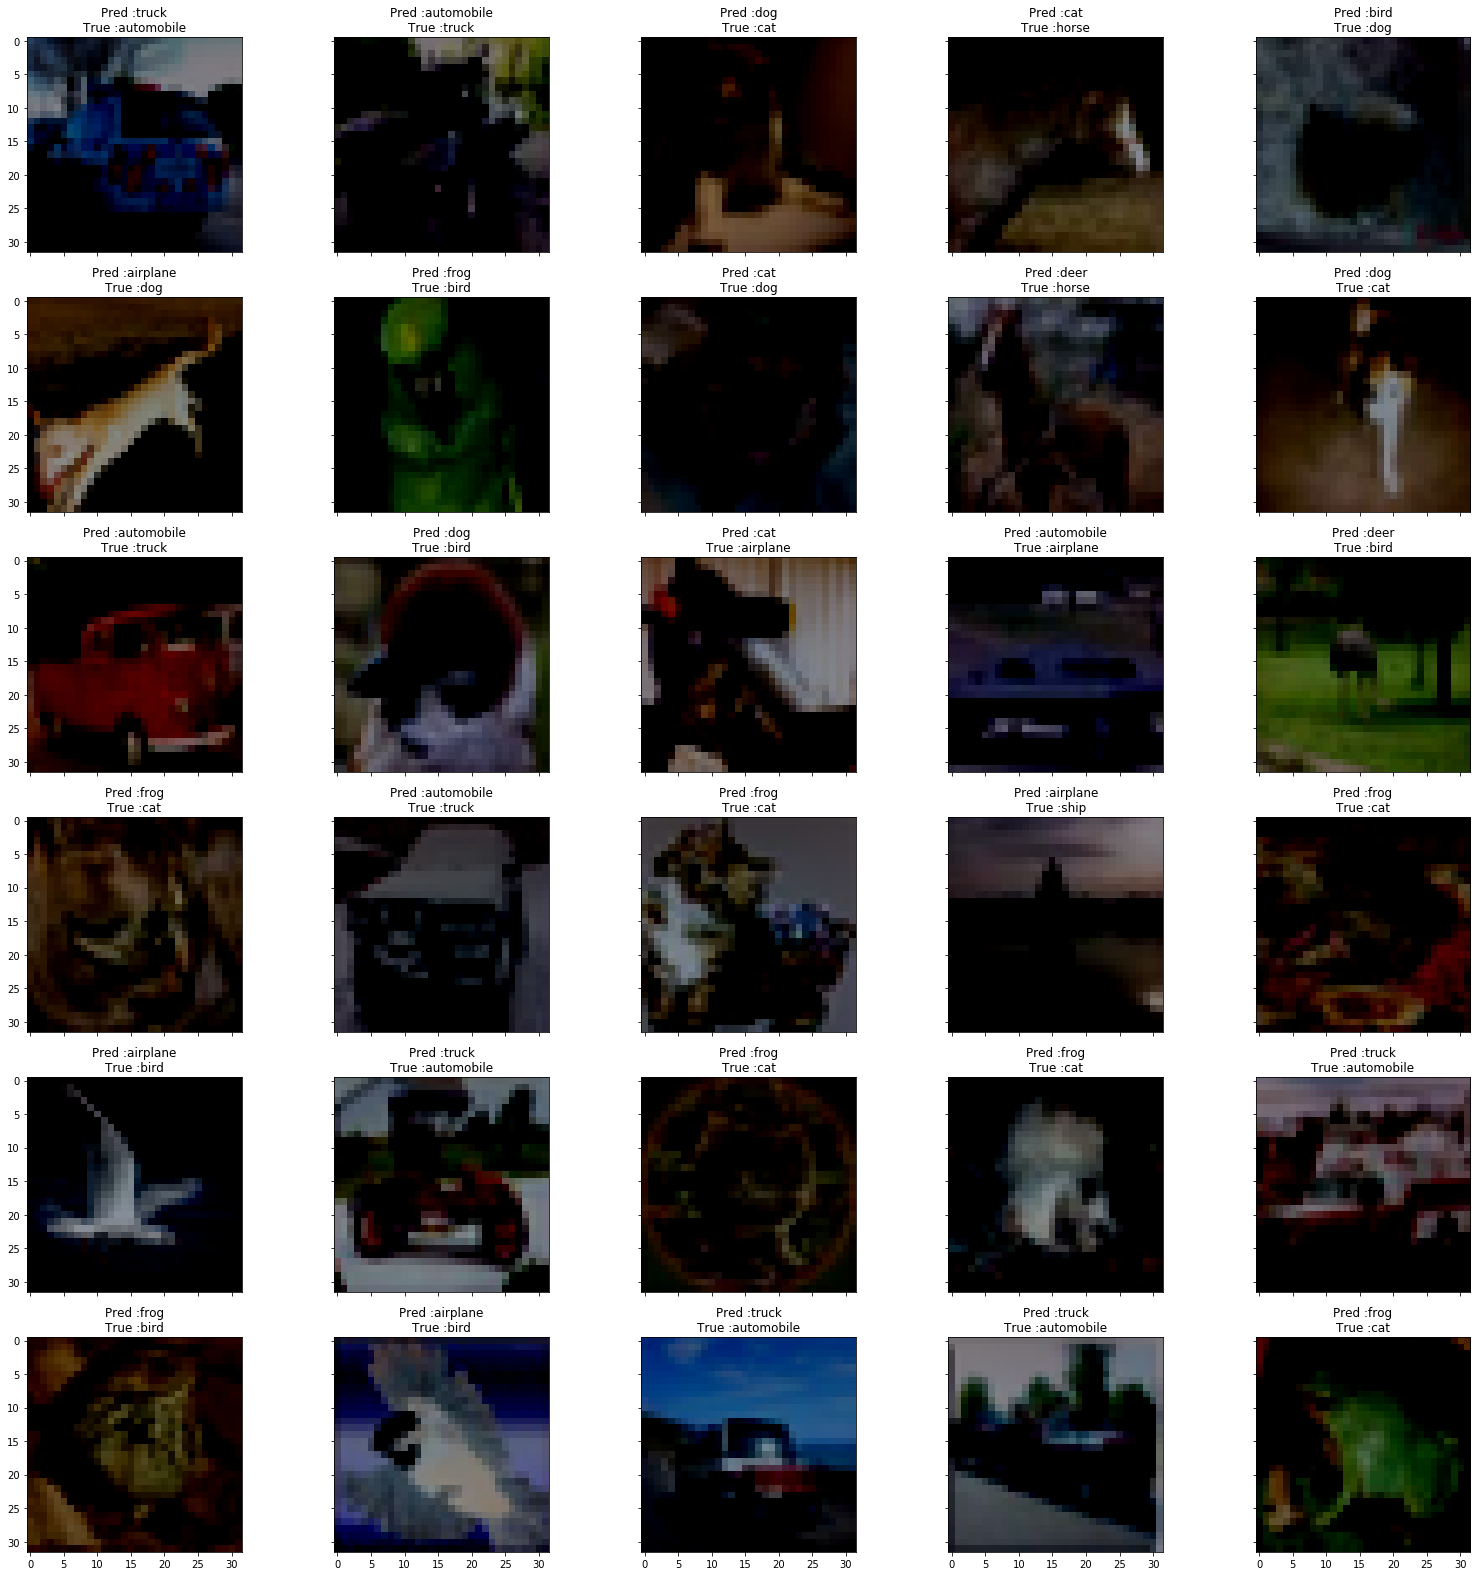

In [0]:
show_metrices.show_misclassified_images_cifar10(Y_pred=Y_pred,Y_true_nor=y_test,X_test=x_test)

In [0]:
import operator
from PIL import Image
from PIL import ImageDraw
from keras import backend as K
import cv2


def show_misclassified_gradcam_heatmap_images(Y_pred,Y_true_nor,X_test):
  from keras import backend as K
  class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  # print(score)
  # Convert validation observations to one hot vectors
  Y_true = np.argmax(Y_true_nor,axis = 1) 
  # Convert predictions classes to one hot vectors 
  Y_pred_classes = np.argmax(Y_pred,axis = 1) 
  # Errors are difference between predicted labels and true labels
  errors = (Y_pred_classes - Y_true != 0)
  errors
  Y_pred_classes_errors = Y_pred_classes[errors]
  pred_errors = Y_pred_classes_errors
  Y_pred_errors = Y_pred[errors]
  Y_true_errors = Y_true[errors]
  obs_errors = Y_true_errors
  
  X_test_errors = X_test[errors]
  img_errors = X_test_errors
  # Probabilities of the wrong predicted numbers
  Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
  # Predicted probabilities of the true values in the error set
  true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
  # Difference between the probability of the predicted label and the true label
  delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
  # Sorted list of the delta prob errors
  sorted_dela_errors = np.argsort(delta_pred_true_errors)
  most_important_errors = sorted_dela_errors[-30:]
  errors_index = most_important_errors
  """ This function shows 6 images with their predicted and real labels"""
#   n = 0
#   nrows = 2
#   ncols = 3
  n = 0
  nrows = 6
  ncols = 5
 
  fig, ax = plt.subplots(nrows,ncols,figsize=(22, 22), sharex=True,sharey=True)
  for row in range(nrows):
    for col in range(ncols):
      error = errors_index[n]
#             print('\n')
#       ax[row,col].imshow((img_errors[error]).reshape((32,32)))
## added for gradcam
      img = np.copy(img_errors[error])
      x = np.expand_dims(img_errors[error], axis=0)
      class_idx = pred_errors[error]
      class_output =  model.output[:, class_idx] ##modelCiphar.output[:, class_idx
      last_conv_layer = model.get_layer("conv2d_30")
      grads = K.gradients(class_output, last_conv_layer.output)[0]
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
      iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
      pooled_grads_value, conv_layer_output_value = iterate([x])
      for i in range(10):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
       
      heatmap = np.mean(conv_layer_output_value, axis=-1)
      heatmap = np.maximum(heatmap, 0)
      heatmap /= np.max(heatmap)
      heatmap = cv2.resize(heatmap, (img_errors[error].shape[1], img_errors[error].shape[0]))
      heatmap = np.uint8(255 * heatmap)

      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
      heatmap = heatmap/255
      
      for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
          if heatmap[i][j][1]<=0.01 and heatmap[i][j][2]<=0.01:
            heatmap[i][j] = 0
        
#       result = Image.blend(img_errors[error], heatmap, alpha=0.5)
      superimposed_img = 0.5*(img_errors[error]) + 0.5*heatmap
      ax[row,col].imshow((superimposed_img))
  ## end of addition for gradcam
#       ax[row,col].imshow((img_errors[error]))
      ax[row,col].set_title("Pred :{}\nTrue :{}".format(class_names[pred_errors[error]],class_names[obs_errors[error]]))
#             print('\n') 
      n += 1
#             print("value:",n)
  # If you don't do tight_layout() you'll have weird overlaps
  plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

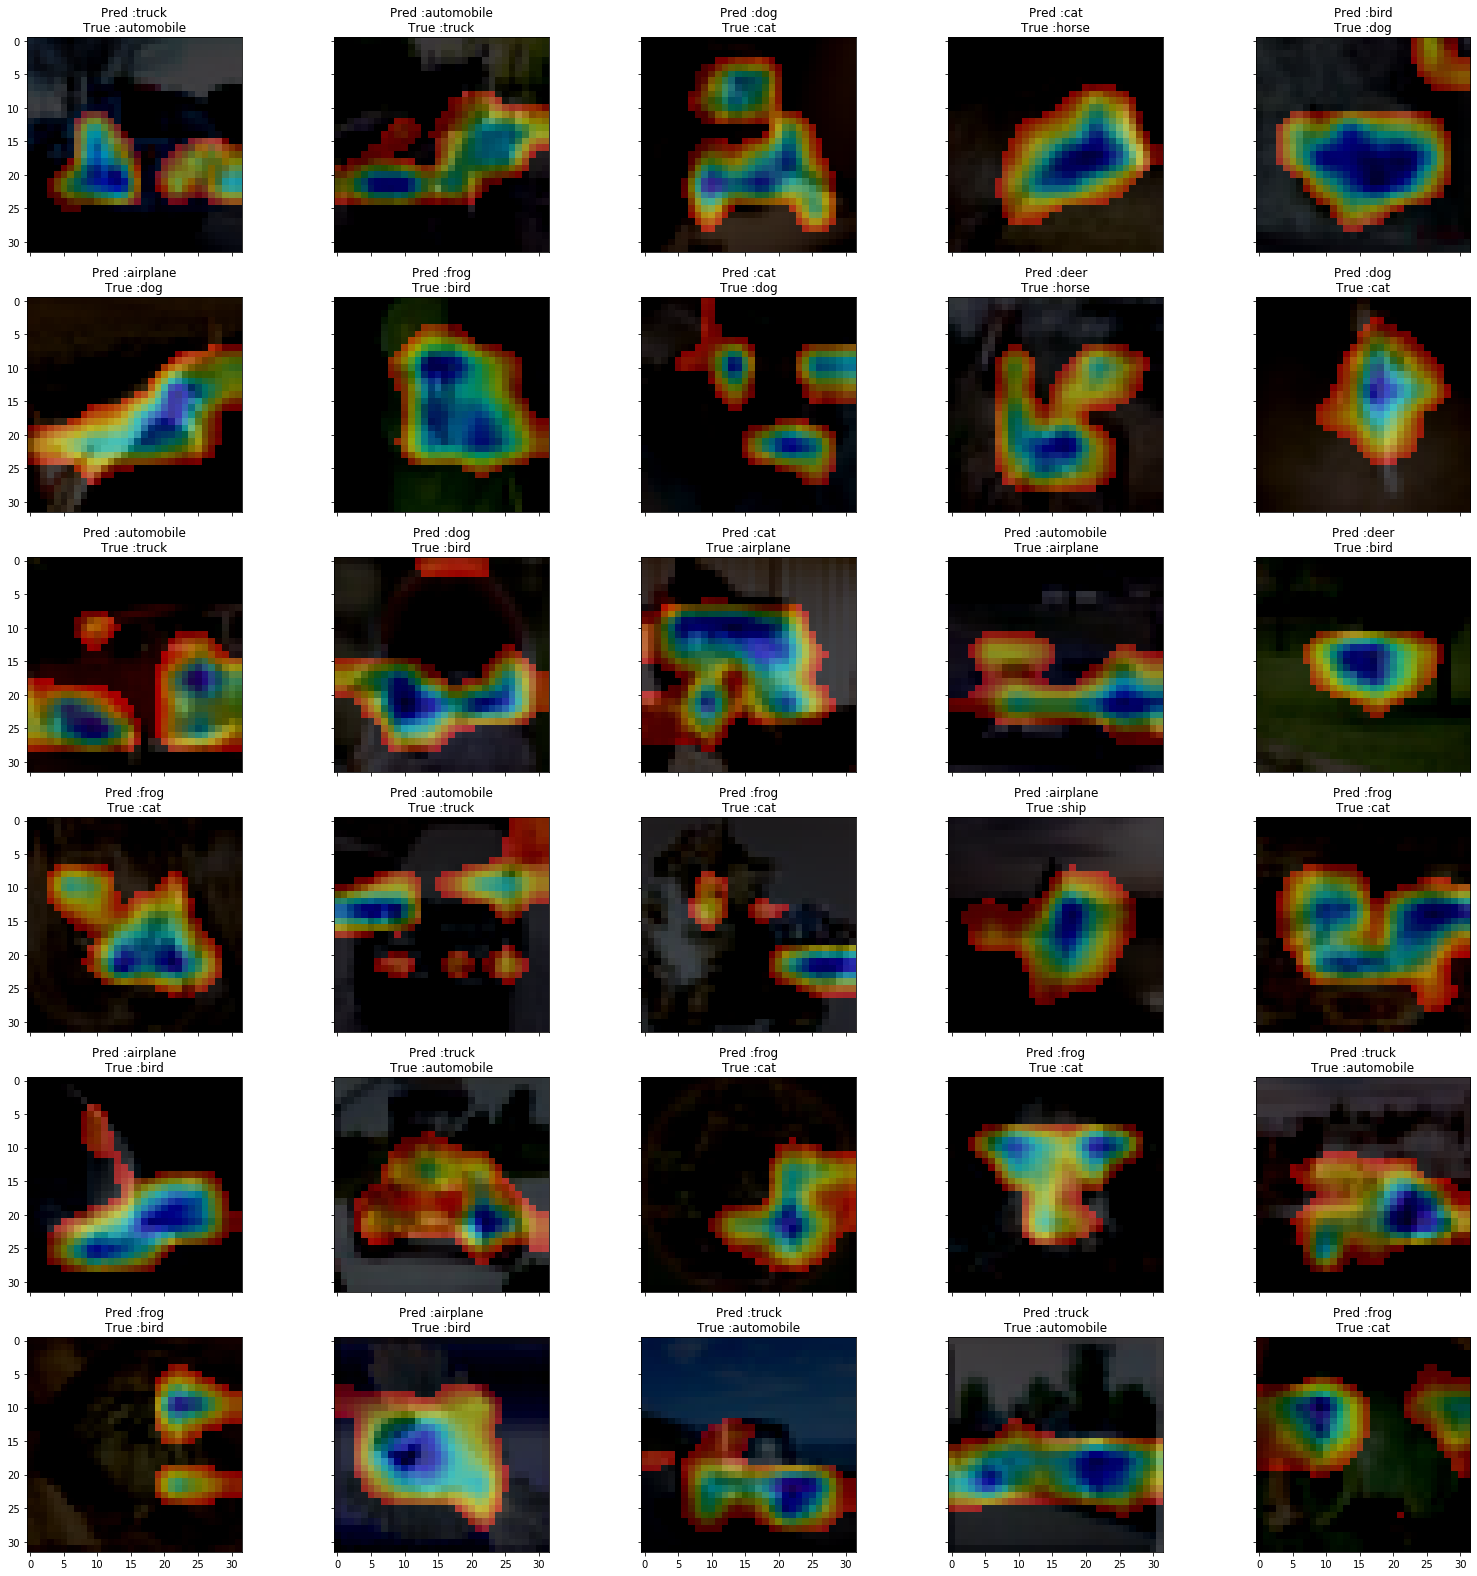

In [0]:
show_misclassified_gradcam_heatmap_images(Y_pred=Y_pred,Y_true_nor=y_test,X_test=x_test)